># 【問題1】仮定関数  
以下の数式で表される線形回帰の仮定関数を実装してください。メソッドの雛形を用意してあります。  

$
h_\theta(x) =  \theta_0 x_0 + \theta_1 x_1 + ... + \theta_j x_j + ... +\theta_n x_n.   (x_0 = 1)\\
$

x: 特徴量ベクトル

θ : パラメータベクトル

n : 特徴量の数


$x_j$: j番目の特徴量

$θ_j$: j番目のパラメータ（重み）

特徴量の数nは任意の値に対応できる実装にしてください。

なお、ベクトル形式で表すと以下のようになります。

$
h_\theta(x) = \theta^T \cdot x.
$


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
warnings.simplefilter("ignore")

># 【問題2】最急降下法  
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fitメソッドから呼び出すようにしてください。

$
\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m}[(h_\theta(x^{(i)}) - y^{(i)} )x_{j}^{(i)}]
$

$α$:学習率

$i$:サンプルのインデックス

$j$:特徴量のインデックス

In [61]:
class ScratchLinearRegression():
    """
    線形回帰のスクラッチ実装
    
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue
    
    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録
    """
    
    def __init__(self, num_iter=5000, lr=1e-5, no_bias=False, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
    def fit(self, X, y, X_val=np.empty(1), y_val=np.empty(1)):
        """
        線形回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.y = y[:,np.newaxis]  #_linear_hypothesisの返り値（行列）にサイズを合わせるためreshapeする
        self.y_val = y_val
        if self.no_bias == False:  #バイアス項がある時
            if X.ndim == 1:  #１次元の時(２次元であればここはスルー)
                X = X[:,np.newaxis]  #バイアス項と結合できるようにXを２次元に変形
            self.X = np.concatenate([np.ones(X.shape[0])[:,np.newaxis],X],axis=1)  #バイアス項を結合
            if(len(X_val) != 1) & (len(y_val) != 1): #検証データが入力された場合（入力されない場合は何もしない）
                if X_val.ndim == 1:  #検証データが１次元の時
                    X_val = X_val[:,np.newaxis]  #バイアス項と結合できるようにXを２次元に変形
                self.X_val = np.concatenate([np.ones(X_val.shape[0])[:,np.newaxis],X_val],axis=1)  #バイアス項を結合
        else:  #バイアス項がない時
            if X.ndim ==1:  #Xが１次元の時
                self.X = X[:,np.newaxis]
                self.X_val = X_val[:,np.newaxis]
            else:  #Xが２次元の時
                self.X = X
                self.X_val = X_val
        
        if (len(X_val) != 1) & (len(y_val) != 1):  #検証データが入力された場合
            error = self._gradient_descent(self.X)
            self.loss[0] = loss_func(self.predict(self.X),y)
            self.val_loss[0] = loss_func(self.predict(self.X_val),y_val)
            for i in range(self.iter-1):  #iter-1回_gradient_descentを実行する
                error = self._gradient_descent(self.X,error)
                self.loss[i+1] = loss_func(self.predict(self.X),y)
                self.val_loss[i+1] = loss_func(self.predict(self.X_val),self.y_val)
                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    print("{}回目".format(i+1))
                    print("theta:{}".format(self.theta))
                    print("損失:{}".format(self.val_loss[i+1]))
                    print("精度（平均2乗誤差）:{}\n".format(MSE(self.predict(self.X_val),self.y_val)))
        else:  #検証データが入力されない場合
            error = self._gradient_descent(self.X)
            self.loss[0] =  loss_func(self.predict(self.X),y)
            for i in range(self.iter-1):
                error = self._gradient_descent(self.X,error)
                self.loss[i+1] = loss_func(self.predict(self.X),y)
                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    print("{}回目".format(i+1))
                    print("theta:\n{}".format(self.theta))
    
    def _gradient_descent(self, X,error=np.empty(1)):
        """
        θとXを用いて次のθを計算する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        
        error:次の形のndarray,shape (n_samples,)
            予測値と正解値の残差
        --------
        Returns
        --------
        次の形のndarray,shape(n_samples,)
        予測値と正解値の残差
        """
        if error.shape == (1,):  #errorが渡されていない時
            self.theta = np.ones(X.shape[1]).reshape(1,-1)#.reshape(1,X.shape[1])  #θを1で初期化
            error = (self._linear_hypothesis(X) - self.y).flatten()
        else:  #errorが渡されている時
            error = (self._linear_hypothesis(X) - self.y).flatten()
            error = (self._linear_hypothesis(X) - self.y).flatten()
        #次に使うθを計算
        self.theta = self.theta - (self.lr/X.shape[0])*error@X
        return error
    
    def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
        線形の仮定関数による推定結果
        """
        if X.ndim == 1:  #Xが１次元の時
            X = X[:,np.newaxis]  #２次元に変形
        if (X.shape[1] != self.theta.T.shape[0])&(self.no_bias==False):
            #x_0が含まれていない状態でXを受け取り（外部からのメソッド呼び出しを想定）、かつバイアス項を使う時
            X = np.concatenate([np.ones(X.shape[0])[:,np.newaxis],X],axis=1)
        return np.dot(X,self.theta.T)
    
    def predict(self, X):
        """
        線形回帰を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        return self._linear_hypothesis(X)

># 【問題3】推定
推定する仕組みを実装してください。ScratchLinearRegressionクラスの雛形に含まれるpredictメソッドに書き加えてください。  
仮定関数$h_\theta(x)$の出力が推定結果です。



上でクラスの中に定義

># 【問題4】平均二乗誤差  
線形回帰の指標値として用いられる平均二乗誤差（mean square error, MSE）の関数を作成してください。
平均二乗誤差関数は回帰問題全般で使える関数のため、ScratchLinearRegressionクラスのメソッドではなく、別の関数として作成してください。雛形を用意してあります。  
平均二乗誤差は以下の数式で表されます。 

>$
L(\theta)=  \frac{1 }{ m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.
$  

>$m$:入力されるデータの数  
$h_\theta()$:仮定関数  
$x^{(i)}$:i番目のサンプルの正解値  
$y^{(i)}$:i番目のサンプルの正解値  
なお、最急降下法のための目的関数（損失関数）としては、これを2で割ったものを使用します。（問題5, 9）

In [3]:
#平均2乗誤差
def MSE(y_pred,y):
    """
    平均二乗誤差の計算

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    mse : numpy.float
      平均二乗誤差
    """
    mse = ((y_pred - y)**2).mean()
    return mse

# 【問題5】目的関数
以下の数式で表される線形回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。  
目的関数（損失関数） $J(\theta)$ は次の式です。  

$
J(\theta)=  \frac{1 }{ 2m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.
$

$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数

$x^{(i)}$ : i番目のサンプルの特徴量ベクトル

$y^{(i)}$ : i番目のサンプルの正解値



In [4]:
#損失関数
def loss_func(y_pred,y):
    return MSE(y_pred,y)/2

# 【問題6】学習と推定
機械学習スクラッチ入門のSprintで用意したHouse Pricesコンペティションのデータに対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。



In [33]:
df = pd.read_csv("../week3/train.csv")
#目的変数と相関関係の高い５つの特徴量
features_list = ["YearBuilt","GrLivArea"]
df_x = df[features_list]
df_y = df.SalePrice

尖度：6.536281860064529
歪度：1.8828757597682129


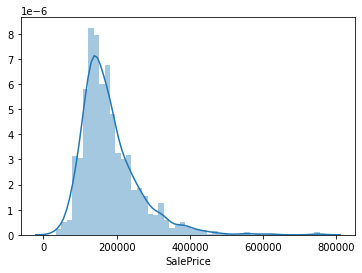

In [34]:
print("尖度：{}".format(df_y.kurt()))
print("歪度：{}".format(df_y.skew()))
sns.distplot(df_y)
plt.show()

尖度：0.8095319958036296
歪度：0.12133506220520406


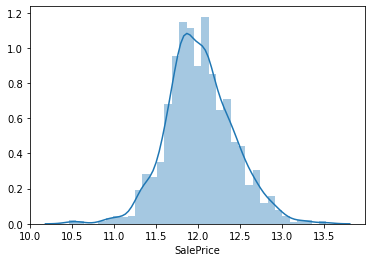

In [35]:
#対数変換を行い、正規分布に近づける

df_x = df_x.apply(np.log)
df_y = df_y.apply(np.log)
print("尖度：{}".format(df_y.kurt()))
print("歪度：{}".format(df_y.skew()))
sns.distplot(df_y)
plt.show()

In [36]:
x_train,x_test,y_train,y_test = \
train_test_split(np.array(df_x),np.array(df_y),train_size = 0.8,random_state=1)
lr = ScratchLinearRegression(verbose=False)
true_lr = LinearRegression()
lr.fit(x_train,y_train,x_test,y_test)
true_lr.fit(x_train,y_train)

LinearRegression()

In [37]:
y_pred = lr.predict(x_test)
true_pred = true_lr.predict(x_test)
print("平均2乗誤差(スクラッチ):{}".format(MSE(y_pred,y_test)))
print("平均2乗誤差(scikit-learn):{}".format(mean_squared_error(true_pred,y_test)))

平均2乗誤差(スクラッチ):0.24084845167707664
平均2乗誤差(scikit-learn):0.0473970949071434


># 【問題7】学習曲線のプロット
学習曲線を表示する関数を作成し、実行してください。グラフを見て損失が適切に下がっているかどうか確認してください。  
線形回帰クラスの雛形ではself.loss, self.val_lossに損失を記録しておくようになっているため、入力にはこれを利用してください。

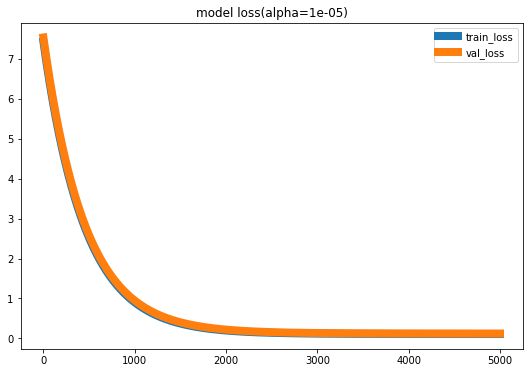

In [38]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_title("model loss(alpha={})".format(lr.lr))
ax.plot(np.arange(len(lr.loss)),lr.loss,label="train_loss",linewidth=8)
ax.plot(np.arange(len(lr.val_loss)),lr.val_loss,label="val_loss",linewidth=8)
ax.legend()
plt.show()

># 【問題8】（アドバンス課題）バイアス項の除去
バイアス項 $\theta_0$ を抜くと学習がどう変化するか検証してください。また、線形回帰モデルにおけるバイアス項の役割の考察・調査を行ってください。

In [39]:
lr2 = ScratchLinearRegression(no_bias=True,verbose=False)
lr2.fit(x_train,y_train,x_test,y_test,)

In [40]:
y_pred2 = lr2.predict(x_test)
print("平均2乗誤差(バイアス項あり):{}".format(MSE(y_pred,y_test)))
print("平均2乗誤差(バイアス項なし):{}".format(MSE(y_pred2,y_test)))
print("バイアス項ありのθ:{}".format(lr.theta))
print("バイアス項なしのθ:{}".format(lr2.theta))

平均2乗誤差(バイアス項あり):0.24084845167707664
平均2乗誤差(バイアス項なし):0.2518453265825777
バイアス項ありのθ:[[0.96578399 0.74053903 0.75149331]]
バイアス項なしのθ:[[0.80677193 0.81469295]]


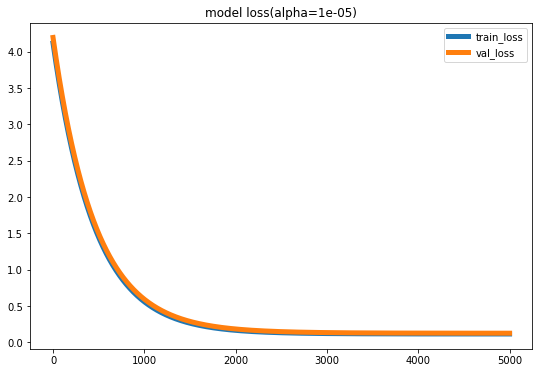

In [41]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_title("model loss(alpha={})".format(lr2.lr))
ax.plot(np.arange(len(lr2.loss)),lr2.loss,label="train_loss",linewidth=5)
ax.plot(np.arange(len(lr2.val_loss)),lr2.val_loss,label="val_loss",linewidth=5)
ax.legend()
plt.show()

ほぼ同じグラフを示しているが平均2乗誤差はバイアス項なしだと数値がやや高くなってしまう。

In [42]:
#特徴量を変えて検証
feature = ["YearBuilt","YearRemodAdd","TotRmsAbvGrd","OverallQual","GrLivArea"]
error = np.empty(15).reshape(3,5)
for i in range(5):
    df_x2 = df[feature[i]].apply(np.log)
    df_y2 = df.SalePrice.apply(np.log)
    x_train,x_test,y_train,y_test = train_test_split(np.array(df_x2),np.array(df_y2),train_size = 0.8,random_state=1)
    lr_bias = ScratchLinearRegression(verbose=False)
    lr_no_bias = ScratchLinearRegression(no_bias=True,verbose=False)
    lr_bias.fit(x_train,y_train,x_test,y_test)
    lr_no_bias.fit(x_train,y_train,x_test,y_test)
    pred_bias = lr_bias.predict(x_test)
    pred_no_bias = lr_no_bias.predict(x_test)
    print("特徴量{}で検証".format(feature[i]))
    print("平均2乗誤差（バイアス項あり）:{}".format(MSE(pred_bias,y_test)))
    print("平均2乗誤差（バイアス項なし）:{}\n".format(MSE(pred_no_bias,y_test)))
    error[0,i] = MSE(pred_bias,y_test)
    error[1,i] = MSE(pred_no_bias,y_test)
    error[2,i] = error[1,i] - error[0,i]
error_data = pd.DataFrame(error,index = ["バイアス項あり","バイアス項なし","バイアス項なし-バイアス項あり"],\
                          columns=feature)
display(error_data)


特徴量YearBuiltで検証
平均2乗誤差（バイアス項あり）:0.19297368159643535
平均2乗誤差（バイアス項なし）:0.21552039154113237

特徴量YearRemodAddで検証
平均2乗誤差（バイアス項あり）:0.19242351433492297
平均2乗誤差（バイアス項なし）:0.21463270680795823

特徴量TotRmsAbvGrdで検証
平均2乗誤差（バイアス項あり）:54.57282545413062
平均2乗誤差（バイアス項なし）:74.10714234731812

特徴量OverallQualで検証
平均2乗誤差（バイアス項あり）:56.733572719407846
平均2乗誤差（バイアス項なし）:76.91847367560985

特徴量GrLivAreaで検証
平均2乗誤差（バイアス項あり）:0.47885036086385524
平均2乗誤差（バイアス項なし）:0.5773639072127514



,YearBuilt,YearRemodAdd,TotRmsAbvGrd,OverallQual,GrLivArea
バイアス項あり,0.192974,0.192424,54.572825,56.733573,0.478850
バイアス項なし,0.215520,0.214633,74.107142,76.918474,0.577364
バイアス項なし-バイアス項あり,0.022547,0.022209,19.534317,20.184901,0.098514


In [75]:
#特徴量の数を変えて検証
feature = ["YearBuilt","YearRemodAdd","TotRmsAbvGrd","OverallQual","GrLivArea"]
error = np.empty(15).reshape(3,5)
for i in range(5):
    df_x2 = df[feature[:i+1]].apply(np.log)
    df_y2 = df.SalePrice.apply(np.log)
    x_train,x_test,y_train,y_test = train_test_split(np.array(df_x2),np.array(df_y2),train_size = 0.8,random_state=1)
    lr_bias = ScratchLinearRegression(verbose=False)
    lr_no_bias = ScratchLinearRegression(no_bias=True,verbose=False)
    lr_bias.fit(x_train,y_train,x_test,y_test)
    lr_no_bias.fit(x_train,y_train,x_test,y_test)
    pred_bias = lr_bias.predict(x_test)
    pred_no_bias = lr_no_bias.predict(x_test)
    print("特徴量{}つで検証".format(i+1))
    print("平均2乗誤差（バイアス項あり）:{}".format(MSE(pred_bias,y_test)))
    print("平均2乗誤差（バイアス項なし）:{}\n".format(MSE(pred_no_bias,y_test)))
    error[0,i] = MSE(pred_bias,y_test)
    error[1,i] = MSE(pred_no_bias,y_test)
    error[2,i] = error[1,i] - error[0,i]
error_data = pd.DataFrame(error,index = ["バイアス項あり","バイアス項なし","バイアス項なし-バイアス項あり"],\
                          columns=[1,2,3,4,5])
display(error_data)


特徴量1つで検証
平均2乗誤差（バイアス項あり）:0.19297368159643535
平均2乗誤差（バイアス項なし）:0.21552039154113237

特徴量2つで検証
平均2乗誤差（バイアス項あり）:0.17730262535794644
平均2乗誤差（バイアス項なし）:0.1770466231893288

特徴量3つで検証
平均2乗誤差（バイアス項あり）:0.22795858950818657
平均2乗誤差（バイアス項なし）:0.22965983336528772

特徴量4つで検証
平均2乗誤差（バイアス項あり）:0.3224436413425831
平均2乗誤差（バイアス項なし）:0.3275902196263335

特徴量5つで検証
平均2乗誤差（バイアス項あり）:0.39907164504286086
平均2乗誤差（バイアス項なし）:0.4144673283050833



,1,2,3,4,5
バイアス項あり,0.192974,0.177303,0.227959,0.322444,0.399072
バイアス項なし,0.215520,0.177047,0.229660,0.327590,0.414467
バイアス項なし-バイアス項あり,0.022547,-0.000256,0.001701,0.005147,0.015396


># [考察]
バイアス項が無い場合、バイアス項の分を他のθを変えることで残差を減らそうとするためθの各値が適切な値から遠のいてしまい、モデルの予測精度が下がる可能性がある。特徴量を変えながら平均2乗誤差を比べてみると、どの場合もバイアス項ありの方が精度が高い。  
特徴量によっては学習率などを変更しないと平均2乗誤差がかなり大きくなってしまうため複数の特徴量を用いる方が誤差は小さくなると感じたので、２つ目の検証では特徴量の数を変えながら指標値を比較した。全体的に平均2乗誤差が小さいため差はかなり小さかったがほとんどの場合はバイアス項ありの方が精度が高い結果が出た。

># 【問題9】（アドバンス課題）特徴量の多次元化
特徴量の二乗や三乗を入力に利用すると学習結果がどう変化するか検証してください。

In [46]:
df_y = df.SalePrice
first_df = df[features_list].apply(np.log)
df_y_f = df_y.apply(np.log)
square_df = (df[features_list]**2).apply(np.log)
df_y_s = (df_y**2).apply(np.log)
third_df = (df[features_list]**3).apply(np.log)
df_y_t = (df_y**3).apply(np.log)
x_train1,x_test1,y_train1,y_test1 = train_test_split(np.array(first_df),np.array(df_y_f),train_size = 0.8,random_state=1)
x_train2,x_test2,y_train2,y_test2 = train_test_split(np.array(square_df),np.array(df_y_s),train_size = 0.8,random_state=1)
x_train3,x_test3,y_train3,y_test3 = train_test_split(np.array(third_df),np.array(df_y_t),train_size = 0.8,random_state=1)
lr_f = ScratchLinearRegression(verbose=False)
lr_s = ScratchLinearRegression(verbose=False)
lr_t = ScratchLinearRegression(verbose=False)
lr_f.fit(x_train1,y_train1)
lr_s.fit(x_train2,y_train2)
lr_t.fit(x_train3,y_train3)
pred_f = lr_f.predict(x_test1)
pred_s = lr_s.predict(x_test2)
pred_t = lr_t.predict(x_test3)
print("特徴量を分析した平均２乗誤差:{}".format(MSE(pred_f,y_test1)))
print("特徴量の２乗を分析した平均２乗誤差:{}".format(MSE(pred_s,y_test2)))
print("特徴量の3乗を分析した平均２乗誤差:{}".format(MSE(pred_t,y_test3)))

特徴量を分析した平均２乗誤差:0.24084845167707664
特徴量の２乗を分析した平均２乗誤差:0.9804099100241516
特徴量の3乗を分析した平均２乗誤差:2.2239677646743963


２乗、３乗していくと値が大きくなるためデータにばらつきが出て精度が下がっていくことがわかる。

># 【問題10】（アドバンス課題）更新式の導出
最急降下法の更新式は以下でした。この式が導出される過程を説明してください。

>$
\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m}[(h_\theta(x^{(i)}) - y^{(i)} )x_{j}^{(i)}]
$

>以下の式から説明をはじめることができます。

>$
\theta_j := \theta_j - \frac{\partial}{\partial \theta_j}J(\theta) \\
$

>目的関数（損失関数） $J(\theta)$ は次の式です。

>$
J(\theta)=  \frac{1 }{ 2m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.
$

$
\theta_j 
$

$
:= \theta_j - \frac{\partial}{\partial \theta_j}J(\theta) \\
$

$
= \theta_j - \frac{\partial}{\partial \theta_j} * \frac{1 }{ 2m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2
$

$
= \theta_j - \frac{1 }{ 2m}\sum_{i=1}^{m}\frac{\partial}{\partial \theta_j}(h_\theta(x^{(i)})-y^{(i)})^2
$

$
=\theta_j - \frac{1 }{ m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})\frac{\partial (h_\theta(x^{(i)})}{\partial \theta_j}
$

$
=\theta_j - \frac{1 }{ m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})\frac{\partial (h_\theta(x^{(i)})}{\partial \theta_j}
$

$
=\theta_j - \alpha\frac{1 }{ m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})x_{j}^{(i)}
$

># 【問題11】（アドバンス課題）局所最適解の問題
最急降下法には一般的に局所最適解の問題があります。しかし、線形回帰では学習を続ければ必ず最適解を求めることができます。それはなぜか数式やグラフを用いて説明してください。

>線形回帰の仮定関数は以下の式で定義される。

>$
h_\theta(x) = \theta_0 x_0 + \theta_1 x_1 + … + \theta_j x_j + … +\theta_n x_n. (x_0 = 1)
$ —①  

>仮定関数①はn次元の変数$\theta_j$の関数であるが、$\theta$の次数はすべて１である。  
また、目的関数である$J(\theta)$は仮定関数①の二乗の関数である。

>$
J(\theta)= \frac{1 }{ 2m} \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.
$　—②

>②は$\theta$の２次方程式となるため、各$\theta$における極値は１点しか持たない。  
そのため、すべてのθにおいて偏微分を行うことで、$J(\theta)$が最小となる極小点が必ず１つ求まる
つまり、局所的最適解に陥ることはない。

># おまけ
イテレーション数を大きくするのとcross validationを用いて、正確にはどの程度の精度が出るのかを検証する

In [72]:
%%time
K = 4
value = 0
kf_price = KFold(n_splits=K,random_state=1)
df_x = df[features_list].apply(np.log)
df_y = df.SalePrice.apply(np.log)

for train_index,test_index in kf_price.split(df):
    x_train,x_test = np.array(df_x.iloc[train_index]),np.array(df_x.iloc[test_index])
    y_train,y_test = np.array(df_y.iloc[train_index]),np.array(df_y.iloc[test_index])
    #線形回帰
    lr = ScratchLinearRegression(num_iter=10000,verbose=False,lr=1e-5)
    lr.fit(x_train,y_train)
    #予測
    y_pred = lr.predict(x_test)
    value += MSE(y_pred,y_test)
print("{}回の平均".format(K))
print("平均２乗誤差:{}".format(value/K))

4回の平均
平均２乗誤差:0.22329778793284416
CPU times: user 1min 47s, sys: 1.35 s, total: 1min 49s
Wall time: 1min 50s


In [69]:
%%time
K = 4
value = 0
kf_price = KFold(n_splits=K,random_state=1)
df_x = df[features_list].apply(np.log)
df_y = df.SalePrice.apply(np.log)

for train_index,test_index in kf_price.split(df):
    x_train,x_test = np.array(df_x.iloc[train_index]),np.array(df_x.iloc[test_index])
    y_train,y_test = np.array(df_y.iloc[train_index]),np.array(df_y.iloc[test_index])
    #線形回帰
    lr = LinearRegression()
    lr.fit(x_train,y_train)
    #予測
    y_pred = lr.predict(x_test)
    value += MSE(y_pred,y_test)
print("{}回の平均".format(K))
print("平均２乗誤差:{}".format(value/K))

4回の平均
平均２乗誤差:0.04575562966944597
CPU times: user 26 ms, sys: 2.64 ms, total: 28.6 ms
Wall time: 8.56 ms


誤差を評価するときはどちらも今回自分で実装したMSEを用いた。  
結果を比べてみると速度の差は明らかな上に、平均２乗誤差もスクラッチ実装した方は本家にかなり劣っていた。イテレーション数や学習率を変えても本家に追いつくことはできなかった。